<a href="https://colab.research.google.com/github/10erick-cpu/Entregas/blob/main/TP7/TP7_Procesamiento_Morfol%C3%B3gico_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Trabajo Práctico VII**

Desarrollar un aplicativo que permita abrir una imagen y automáticamente convertirla a niveles de grises (en caso de no estarlo) y visualizarla. Con esta imagen se aplicarán los siguientes filtros morfológicos, los cuales deben poderse seleccionar de una lista:

- Erosión (tomar el mínimo valor de luminancia de la vecindad).
- Dilatación (máximo)
- Apertura
-Cierre
- Borde morfológico (frontera interna y externa)
- Mediana
- Top-hat

El elemento estructurante será de una ventana de 3x3 pixeles.
El aplicativo debe incluir una función de copiado de la imagen procesada, de tal manera que esta pueda tomarse como imagen de entrada para así poder aplicar dos o más filtros en secuencia.
El resultado del filtro debe poder guardarse como una nueva imagen en nivel de grises.
Adicionalmente se debe mostrar un plot con el resultado respectivo para cada uno de los filtros indicados.

**Nota**: La función que desarrollaron para la convolución es la misma que pueden usar para recorrer toda la imagen y aplicar el filtro morfológico.





### **Alumno** : Erick Macote Yparraguirre
### **mail** : leonelerick59@gmail.com
### **Profesor** : Steven Martinez Vargas


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Librerias Usadas**

In [196]:
import matplotlib.pyplot as plt 
import numpy as np
import imageio as io
from scipy import fftpack
import numpy.fft
import numpy.fft as fp
from PIL import Image
import math


# **Función para leer la imágen y mostrarla**

(150, 112, 3) <class 'numpy.ndarray'>


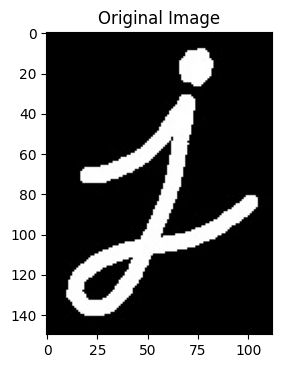

In [197]:
### Función para leer la Imagen y convertirlo en array ###

def read_ima(path):
    ima = np.asarray(Image.open(path))
    print(ima.shape, type(ima))
    return ima

### Función para leer los canales RGB ###

def channels_ima(ima):
    r, g, b = ima[:, :, 0], ima[:, :, 1], ima[:, :, 2]
    return r, g, b

# r,g,b= channels_ima(im_a)
# print(r,g,b)


## Defino el path ##

path1='/content/j.jpg'

## Leemos la Imagen en función del path ##

ima1 = read_ima(path1)

### Graficamos la imagen 1 ###

def plot_image(im, title, cmap=None):
  fig, ax = plt.subplots(dpi=100)
  ax.imshow(im, cmap=cmap)
  ax.set_title(title)
  plt.axis('on')
  plt.show()

plot_image(ima1,title='Original Image')

#**Convertimos cada pixel de la imagen del espacio RGB al espacio YIQ para trabajar con la Luminancia**

In [198]:
### Función para leer los canales RGB - Normalizamos para pasar de RGB a YIQ ###

def channels_ima(ima):
    r, g, b = ima[:, :, 0]/255.0, ima[:, :, 1]/255.0, ima[:, :, 2]/255.0
    return r, g, b

ra,ga,ba = channels_ima(ima1)


### Funciones para trabajar en los espacios RGB - YIQ -- Canales independientes ##

def trans_rgb_to_yiq(r,g,b):
    y= 0.299*r + 0.587*g + 0.114*b
    i= 0.595716*r - 0.274453*g - 0.321263*b
    q= 0.211456*r - 0.522591*g + 0.311135*b 
    return y,i,q

def trans_yiq_to_rgb(y,i,q):
    r= ( y + 0.9663*i + 0.6210*q)*255.0
    g= (y - 0.2721*i - 0.6474*q)*255.0
    b= (y - 1.1070*i + 1.7046*q)*255.0
    return clip_rgb(r,g,b)

####  Funciones para Clipear los espacios YIQ & RGB ####

def clip_rgb(r,g,b): 
  r=np.clip(r,0,255)
  g=np.clip(g,0,255)
  b=np.clip(g,0,255)
  return r,g,b

def clip_yiq(y,i,q):
  y=np.clip(y,0,1)
  i=np.clip(i,-0.5957,0.5957)
  q=np.clip(q,-0.5226,0.5226)
  return y,i,q

# **Valores de Ya Ia Qa - Imágen A**

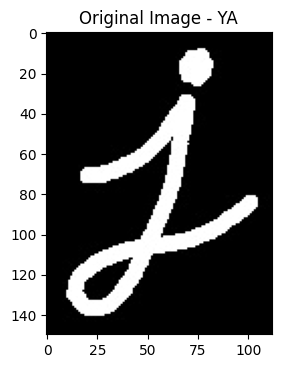

In [199]:
### Valores de Y I Q , para la imagen A

Ra,Ga,Ba = clip_rgb(ra,ga,ba)

#### Trasformacion del Espacio RGB al Espacio YIQ  ####

Ya,Ia,Qa = trans_rgb_to_yiq(Ra,Ga,Ba)

# Ya,Ia,Qa = trans_rgb_to_yiq(ra,ga,ba)

YA,IA,QA = clip_yiq(Ya,Ia,Qa)

# Obtenemos la Luminancia

YA

# Ploteamos la Luminancia 

plot_image(YA ,title='Original Image - YA',cmap='gray')

# Guardamos la Imagen para su visualizacion al final

io.imwrite('Original_Image_YA.png',(YA*255).astype('uint8'))




# **Filtros Morfológicos**

# **Erosión (tomar el mínimo valor de luminancia de la vecindad)**.

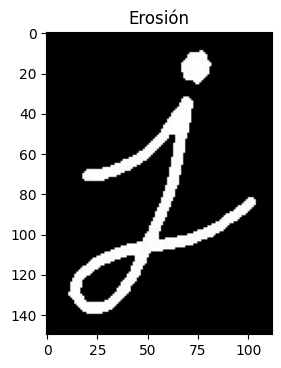

In [200]:
### Tamaño de la imagen Original (Entrada YA)

m,n= YA.shape 

## Definimos el Elemento Estructurante

k=3

SE= np.ones((k,k), dtype=np.uint8)

constant= (k-1)//2


# Definimos una nueva Imagen

imgErode= np.zeros((m,n), dtype=np.uint8)

## Aplicamos Erosión 

for i in range(constant, m-constant):
  for j in range(constant,n-constant):
    temp= YA[i-constant:i+constant+1, j-constant:j+constant+1]
    product= (temp*SE)*255
    imgErode[i,j]= np.min(product)

# Ploteamos la Erosion

plot_image(imgErode ,title='Erosión',cmap='gray')

# Guardamos la Imagen para su visualizacion al final

io.imwrite('Erosion.png',imgErode.astype('uint8'))


# **Dilatación (máximo)**

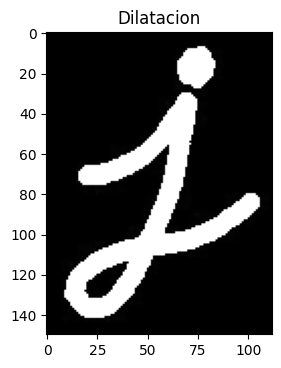

In [201]:
### Tamaño de la imagen

m,n= YA.shape 

# Definimos una nueva imagen para almacenar los píxeles de la imagen dilatada

imgDilate= np.zeros((m,n), dtype=np.uint8)

# Definimos en el Elemento Estructurante

SED= np.array([[0,1,0], [1,1,1],[0,1,0]])

constant1=1

# Aplicamos Dilatación 

for i in range(constant1, m-constant1):
  for j in range(constant1,n-constant1):
    temp1= YA[i-constant1:i+constant1+1, j-constant1:j+constant1+1]
    product1= (temp1*SED)*255
    imgDilate[i,j]= np.max(product1)
  

# Ploteamos la Dilatación

plot_image(imgDilate,title='Dilatacion',cmap='gray')

# Guardamos la Imagen para su visualizacion al final

io.imwrite('Dilatacion.png',imgDilate.astype('uint8'))


# **Ploteo / Imágen Original - Erosión - Dilatación**

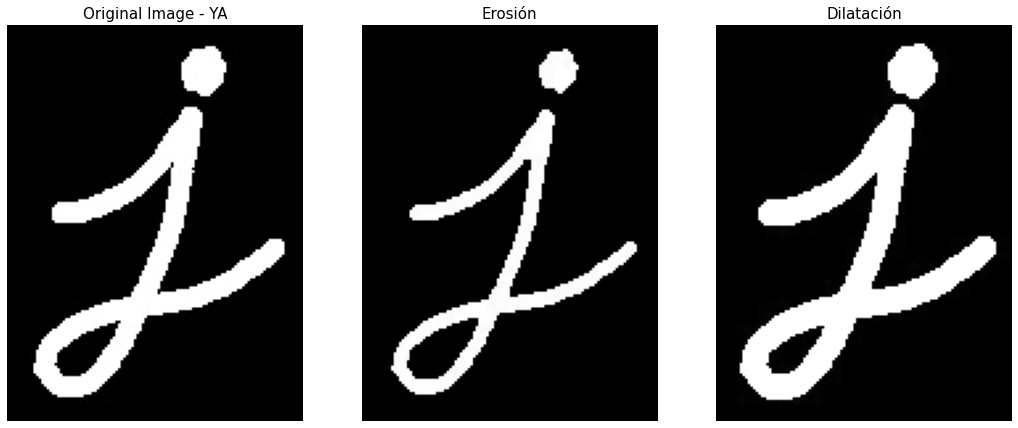

In [202]:
plt.figure(figsize=(18,15))

plt.subplot(131)
plt.imshow(YA,cmap='gray')
plt.title('Original Image - YA',fontsize=15),plt.axis('off') 

plt.subplot(132)
plt.imshow(imgErode,cmap='gray')
plt.title('Erosión',fontsize=15),plt.axis('off')

plt.subplot(133)
plt.imshow(imgDilate,cmap='gray')
plt.title('Dilatación',fontsize=15),plt.axis('off') 

plt.show()


# **Apertura (erosión seguida por dilatación)**

<Figure size 1080x1080 with 0 Axes>

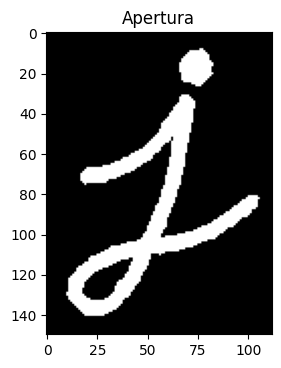

In [203]:
### Tamaño de la imagen Erosionada como entrada

m,n= imgErode.shape 

# Definimos una nueva imagen para almacenar los píxeles de la imagen dilatada

imgDilate1= np.zeros((m,n), dtype=np.uint8)

# Definimos en el Elemento Estructurante

SED= np.array([[0,1,0], [1,1,1],[0,1,0]])

constant2=1

# Aplicamos Dilatación a la imagen erosionada

for i in range(constant2, m-constant2):
  for j in range(constant2,n-constant2):
    temp2= imgErode[i-constant2:i+constant2+1, j-constant2:j+constant2+1]
    product2= (temp2*SED)
    imgDilate1[i,j]= np.clip(np.max(product2),0,1)



# Ploteamos la Apertura

plt.figure(figsize=(15,15))
plot_image(imgDilate1 ,title='Apertura',cmap='gray')


# Guardamos la Imagen para su visualizacion al final

io.imwrite('Apertura.png',(imgDilate1*255).astype('uint8'))



# **Cierre (dilatación seguida por erosión)**

<Figure size 1080x1080 with 0 Axes>

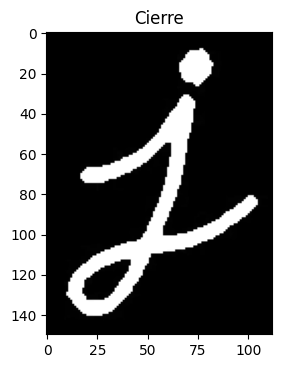

In [204]:
### Tamaño de la imagen dilatada

m,n= imgDilate.shape 

## Definimos el Elemento Estructurante

k=3

SE= np.ones((k,k), dtype=np.uint8)

constant3= (k-1)//2


# Definimos una nueva Imagen

imgErode1= np.zeros((m,n), dtype=np.uint8)

## Aplicamos Erosión  a la imagen dilatada

for i in range(constant3, m-constant3):
  for j in range(constant3,n-constant3):
    temp3= imgDilate[i-constant3:i+constant3+1, j-constant3:j+constant3+1]
    product3= (temp3*SE)
    imgErode1[i,j]= np.min(product3)


# Ploteamos el Cierre

plt.figure(figsize=(15,15))
plot_image(imgErode1 ,title='Cierre',cmap='gray')

# Guardamos la Imagen para su visualizacion al final
io.imwrite('Cierre.png',(imgErode1).astype('uint8'))

# **Borde morfológico (frontera interna y externa)**

# **Borde Externo**

<Figure size 1080x1080 with 0 Axes>

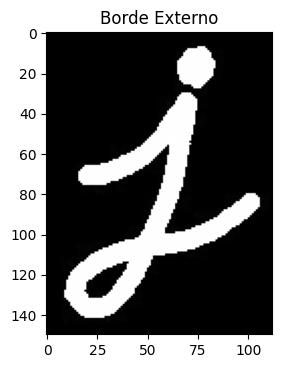

In [205]:
YBe = (imgDilate - YA)/255

# YBe = (imgDilate - YA)

YBE = np.clip(YBe,0,1)


# Ploteamos Borde Externo
plt.figure(figsize=(15,15))
plot_image(YBE ,title='Borde Externo',cmap='gray')

# Guardamos la Imagen para su visualizacion al final
io.imwrite('Borde_Externo.png',(YBE*255).astype('uint8'))

# **Borde Interno**

<Figure size 1080x1080 with 0 Axes>

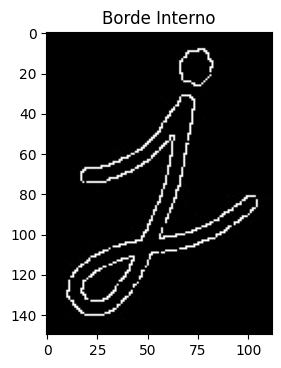

In [216]:
YBi = (YA - imgErode)
YBI = np.clip(YBi,0,1)


# Ploteamos el borde interno
plt.figure(figsize=(15,15))
plot_image(YBI ,title='Borde Interno',cmap='gray')


# Guardamos la Imagen para su visualizacion al final
io.imwrite('Borde_Interno.png',(YBI*255).astype('uint8'))

# **Gradiente**



<Figure size 1080x1080 with 0 Axes>

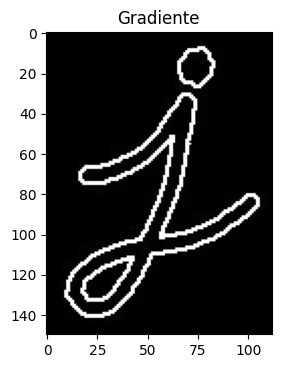

In [217]:
Ygr = (imgDilate -imgErode)/255
Ygrad = np.clip(Ygr,0,1)

# Ploteamos Gradiente

plt.figure(figsize=(15,15))
plot_image(Ygrad ,title='Gradiente',cmap='gray')


# Guardamos la Imagen para su visualizacion al final
io.imwrite('Gradiente.png',(Ygrad*255).astype('uint8'))


# **Mediana**

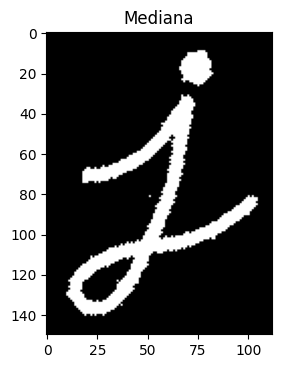

In [218]:
### Tamaño de la imagen

m,n= YA.shape 

# Definimos una nueva imagen para almacenar los píxeles de la imagen 

imgMed= np.zeros((m,n), dtype=np.uint8)

# Definimos en el Elemento Estructurante

SEM= np.array([[0,1,0], [1,1,1],[0,1,0]])
constant4=1

# k = 3
# SE= np.ones((k,k), dtype=np.uint8)
# constant4= (k-1)//2

# Median Code

for i in range(constant4, m-constant4):
  for j in range(constant4,n-constant4):
    temp4= YA[i-constant4:i+constant4+1, j-constant4:j+constant4+1]
    product4= (temp4*SEM)*255
    imgMed[i,j]= np.clip(np.median(product4),0,1)


# Ploteamos la Mediana
plot_image(imgMed,title='Mediana',cmap='gray')

# Guardamos la Imagen para su visualizacion al final
io.imwrite('Mediana.png',(imgMed*255).astype('uint8'))


# **Top-Hat ( Imágen - Apertura)**

<Figure size 1080x1080 with 0 Axes>

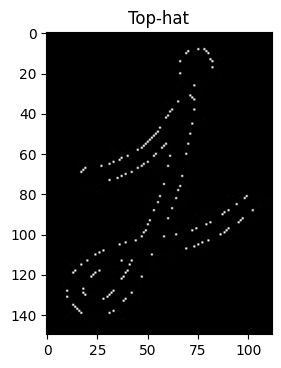

In [219]:
Ytop = (YA -imgDilate1)
YTophat = np.clip(Ytop,0,1)

# Ploteamos Top-Hat

plt.figure(figsize=(15,15))
plot_image(YTophat,title='Top-hat',cmap='gray')

# Guardamos la Imagen para su visualizacion al final
io.imwrite('Top-hat.png',(YTophat*255).astype('uint8'))

# **Gráficos - Filtros Morfólogicos**

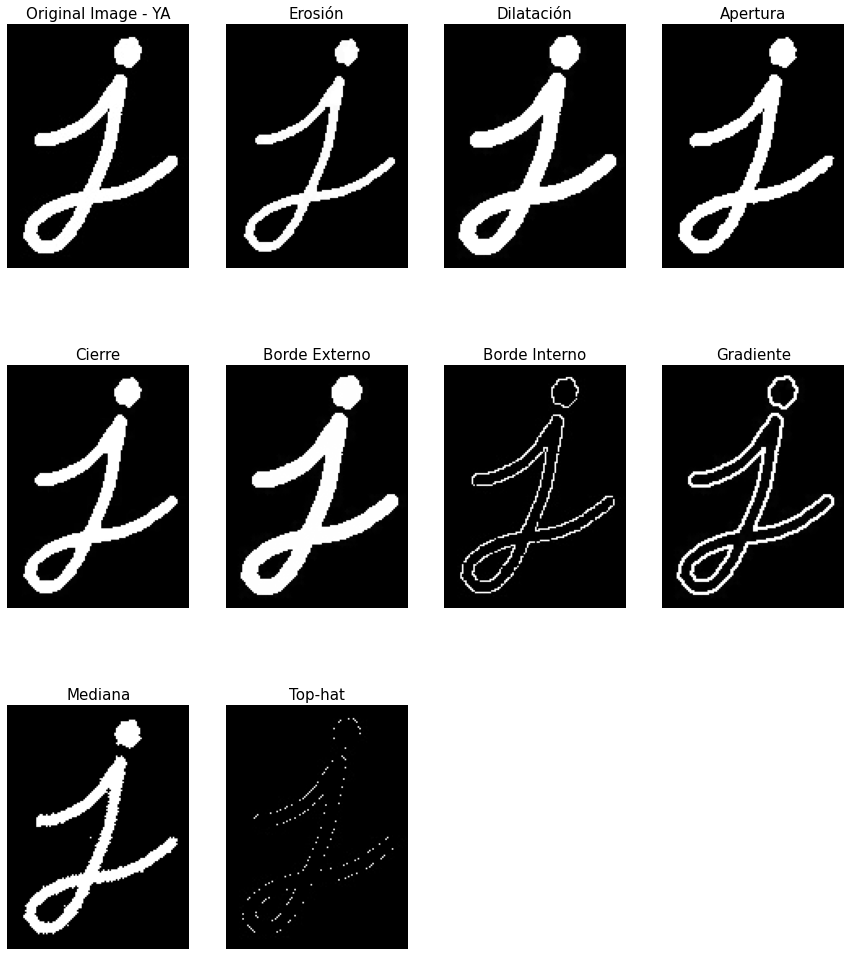

In [220]:
plt.figure(figsize=(15,24))

plt.subplot(441)
plt.imshow(YA,cmap='gray')
plt.title('Original Image - YA',fontsize=15),plt.axis('off') 

plt.subplot(442)
plt.imshow(imgErode,cmap='gray')
plt.title('Erosión',fontsize=15),plt.axis('off')

plt.subplot(443)
plt.imshow(imgDilate,cmap='gray')
plt.title('Dilatación',fontsize=15),plt.axis('off') 

plt.subplot(444)
plt.imshow(np.clip(imgDilate1,0,1),cmap='gray')
plt.title('Apertura',fontsize=15),plt.axis('off') 

plt.subplot(445)
plt.imshow(imgErode1,cmap='gray')
plt.title('Cierre',fontsize=15),plt.axis('off') 

plt.subplot(446)
plt.imshow(YBE,cmap='gray')
plt.title('Borde Externo',fontsize=15),plt.axis('off') 

plt.subplot(447)
plt.imshow(YBI,cmap='gray')
plt.title('Borde Interno',fontsize=15),plt.axis('off') 


plt.subplot(448)
plt.imshow(Ygrad,cmap='gray')
plt.title('Gradiente',fontsize=15),plt.axis('off') 


plt.subplot(449)
plt.imshow(imgMed,cmap='gray')
plt.title('Mediana',fontsize=15),plt.axis('off') 


plt.subplot(4,4,10)
plt.imshow(YTophat,cmap='gray')
plt.title('Top-hat',fontsize=15),plt.axis('off') 


plt.show()

# **Función para leer las imagenes**




In [221]:
def get_image(rute):
  im = io.imread(rute)
  im = im.astype(np.int)
  return im

## Path de imagenes ##

## Luminacia de la Imagen

Imagen_Original_YA = '/content/Original_Image_YA.png' # Luminancia

## Filtros Morfologicos

Erosion = '/content/Erosion.png'  
Dilatacion = '/content/Dilatacion.png'
Apertura = '/content/Apertura.png'
Cierre = '/content/Cierre.png'
Borde_Externo ='/content/Borde_Externo.png'
Borde_Interno ='/content/Borde_Interno.png'
Gradiente = '/content/Gradiente.png'
Mediana = '/content/Mediana.png'
Top_hat='/content/Top-hat.png'


# **Aplicativo - Filtros Morfologicos**

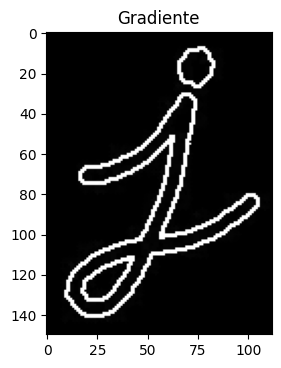

In [223]:
#@title Espacio RGB - Selecccione una Imágen. { run: "auto" }

Imagen = 'Gradiente' #@param ["Imagen_Original_YA","Erosion","Dilatacion","Apertura","Cierre","Borde_Externo","Borde_Interno","Gradiente","Mediana","Top_hat"]


if Imagen =='Imagen_Original_YA':
  im = get_image(Imagen_Original_YA)
  plot_image(im,'Imagen_Original_YA','gray')

elif Imagen =='Erosion':
  im = get_image(Erosion)
  plot_image(im,'Erosión','gray')

elif Imagen =='Dilatacion':
  im = get_image(Dilatacion)
  plot_image(im,'Dilatación','gray')

elif Imagen =='Apertura':
  im = get_image(Apertura)
  plot_image(im,'Apertura','gray')

elif Imagen =='Cierre':
  im = get_image(Cierre)
  plot_image(im,'Cierre','gray')

elif Imagen =='Borde_Externo':
  im = get_image(Borde_Externo)
  plot_image(im,'Borde_Externo','gray')

elif Imagen =='Borde_Interno':
  im = get_image(Borde_Interno)
  plot_image(im,'Borde_Interno','gray')

elif Imagen =='Gradiente':
  im = get_image(Gradiente)
  plot_image(im,'Gradiente','gray')

elif Imagen =='Mediana':
  im = get_image(Mediana)
  plot_image(im,'Mediana','gray')

elif Imagen =='Top_hat':
  im = get_image(Top_hat)
  plot_image(im,'Top_hat','gray')




# **Desarrollo de Aplicativo - Aplicacion de 2 Filtros o más**

# Incluye una función de copiado de la imagen procesada, de tal manera que esta pueda tomarse como imagen de entrada para así poder aplicar dos o más filtros en secuencia.






# **Imagenes de Entrada**

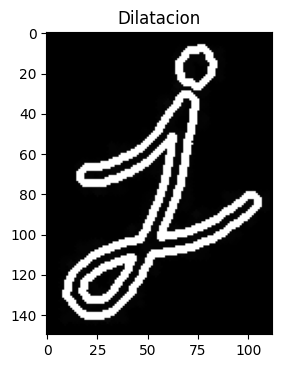

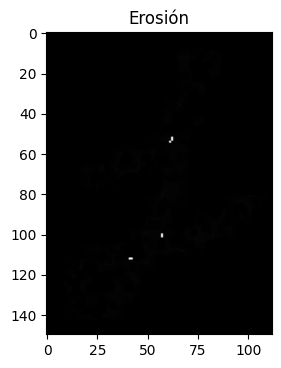

<Figure size 1080x1080 with 0 Axes>

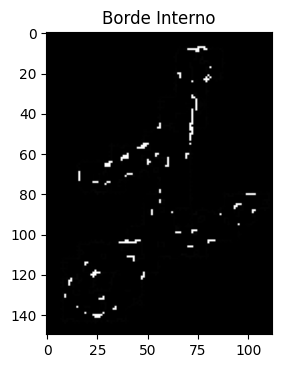

In [224]:
 Ygrad

 # # Guardamos la Imagen para su visualizacion al final

io.imwrite('Imagen_Orig_Ygrad.png', (Ygrad*255).astype('uint8'))


## A  Ygrad Aplicamos Dilatacion - Erosion - Borde Interno
####### Dilatacion #########

### Tamaño de la imagen

m,n= Ygrad.shape 

# Definimos una nueva imagen para almacenar los píxeles de la imagen dilatada

imgDilate_= np.zeros((m,n), dtype=np.uint8)

# Definimos en el Elemento Estructurante

SED= np.array([[0,1,0], [1,1,1],[0,1,0]])

constant1=1

# Aplicamos Dilatación 

for i in range(constant1, m-constant1):
  for j in range(constant1,n-constant1):
    temp1= Ygrad[i-constant1:i+constant1+1, j-constant1:j+constant1+1]
    product1= (temp1*SED)*255
    imgDilate_[i,j]= np.max(product1)
  

# Ploteamos la Dilatación

plot_image(imgDilate_,title='Dilatacion',cmap='gray')

# Guardamos la Imagen para su visualizacion al final

io.imwrite('Dilatacion_Ygrad.png',imgDilate_.astype('uint8'))


####### Erosion #######

### Tamaño de la imagen Original (Entrada YA)

m,n=  Ygrad.shape 

## Definimos el Elemento Estructurante

k=3

SE= np.ones((k,k), dtype=np.uint8)

constant= (k-1)//2


# Definimos una nueva Imagen

imgErode_= np.zeros((m,n), dtype=np.uint8)

## Aplicamos Erosión 

for i in range(constant, m-constant):
  for j in range(constant,n-constant):
    temp =  Ygrad[i-constant:i+constant+1, j-constant:j+constant+1]
    product = (temp*SE)*255
    imgErode_[i,j]= np.min(product)

# Ploteamos la Erosion

plot_image(imgErode_,title='Erosión',cmap='gray')

# # Guardamos la Imagen para su visualizacion al final

io.imwrite('Erosion_Ygrad.png',imgErode_.astype('uint8'))



#### Borde Interno ##################


YBi_ = ( Ygrad- imgErode_)
YBI_ = np.clip(YBi_,0,1)


# Ploteamos el borde interno
plt.figure(figsize=(15,15))
plot_image(YBI_ ,title='Borde Interno',cmap='gray')



# # Guardamos la Imagen para su visualizacion al final

io.imwrite('Borde_Interno_Ygrad.png',(YBI_*255).astype('uint8'))


# **Ploteo - Imagen de Entrada - Dilatacion - Erosion**

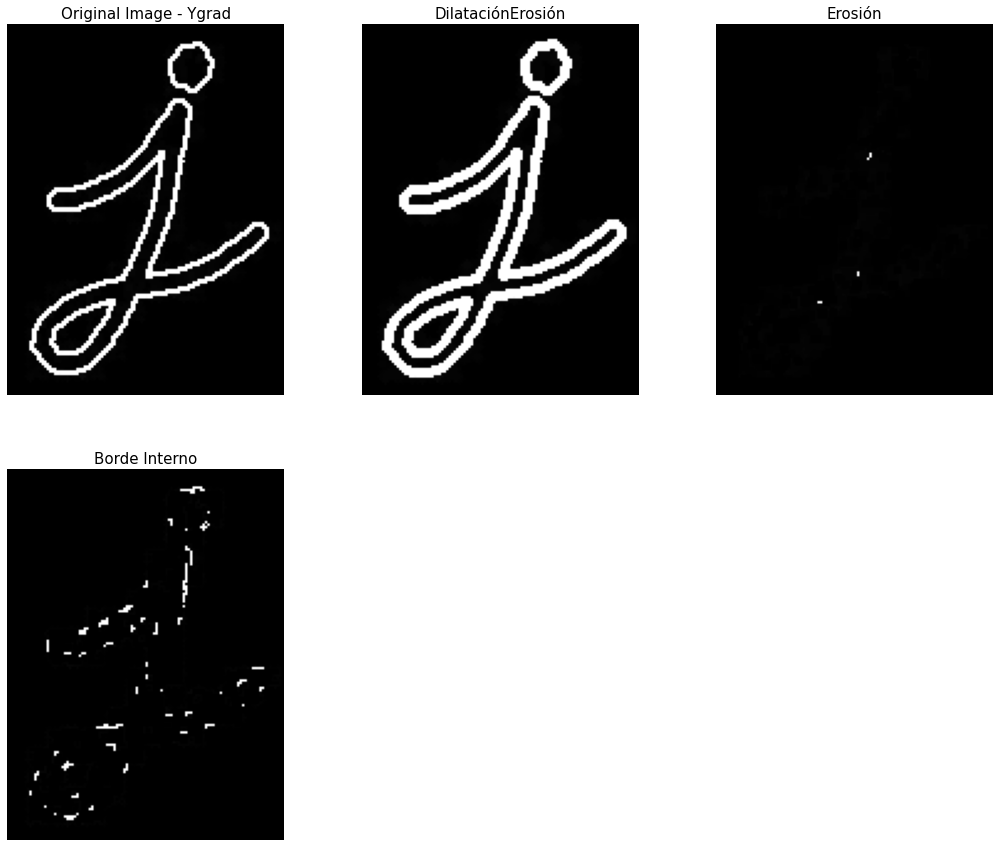

In [225]:
plt.figure(figsize=(18,15))

plt.subplot(231)
plt.imshow( Ygrad,cmap='gray')
plt.title('Original Image - Ygrad',fontsize=15),plt.axis('off') 

plt.subplot(232)
plt.imshow(imgDilate_,cmap='gray')
plt.title('DilataciónErosión',fontsize=15),plt.axis('off')

plt.subplot(233)
plt.imshow( imgErode_,cmap='gray')
plt.title('Erosión',fontsize=15),plt.axis('off') 

plt.subplot(234)
plt.imshow(YBI_,cmap='gray')
plt.title('Borde Interno',fontsize=15),plt.axis('off') 


plt.show()

# **Aplicativo con Imagen de Entrada**

# **Función para leer las imagenes**




In [226]:
def get_image(rute):
  im = io.imread(rute)
  im = im.astype(np.int)
  return im

## Path de imagenes ##

## Luminacia de la Imagen

Original_Ygrad = '/content/Imagen_Orig_Ygrad.png' # Imagen de Entrada

## Filtros Morfologicos

Dilatacion_Ygrad = '/content/Dilatacion_Ygrad.png'
Erosion_Ygrad = '/content/Erosion_Ygrad.png'  
Borde_Interno_Ygrad ='/content/Borde_Interno_Ygrad.png'


# **Aplicativo - Filtros Morfologicos**

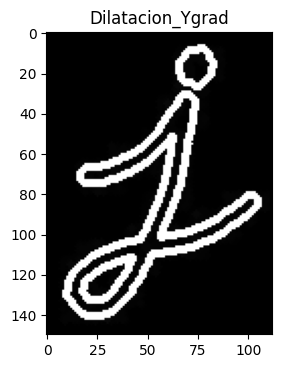

In [228]:
#@title Espacio RGB - Selecccione una Imágen. { run: "auto" }

Imagen = 'Dilatacion_Ygrad' #@param ["Original_Ygrad","Dilatacion_Ygrad","Erosion_Ygrad","Borde_Interno_Ygrad"]


if Imagen =='Original_Ygrad':
  im = get_image(Original_Ygrad)
  plot_image(im,'Original_Ygrad','gray')

elif Imagen =='Dilatacion_Ygrad':
  im = get_image(Dilatacion_Ygrad)
  plot_image(im,'Dilatacion_Ygrad','gray')

elif Imagen =='Erosion_Ygrad':
  im = get_image(Erosion_Ygrad)
  plot_image(im,'Erosion_Ygrad','gray')


elif Imagen =='Borde_Interno_Ygrad':
  im = get_image(Borde_Interno_Ygrad)
  plot_image(im,'Borde_Interno_Ygrad','gray')

